In [1]:
!pip install adjustText spacy matplotlib pandas numpy
!python -m spacy download ru_core_news_sm


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 15.3/15.3 MB 2.0 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
from adjustText import adjust_text
from typing import Optional, Set, Dict
import matplotlib.pyplot as plt
import pandas as pd
import re
import spacy
from collections import Counter
import numpy as np

# Load texts data from Excel file
add auto increment index for markdown file


In [34]:
users_msgs_df = pd.read_excel("message_dataset.xlsx", usecols=['person_id', 'person_text', 'text_length'], index_col=False)
users_msgs_df.sample(n=5).head()

,person_id,person_text,text_length
21,21,"Привет Устала сегодня очень, много дел по дому...",10835
24,24,Привет Хорошо Работаю сантехником и кто как хо...,10644
23,23,Доброе утро)) Хмм .. ну я люблю шить )) подумы...,10655
25,25,Привет Чем занимаешься? Талант А я в универе Н...,10607
13,13,Привет Я поздно ложусь Сладкое не люблю Играю ...,11481


# Clean all symbols exclude space and Russian letters, make all letters lowercase, replace all words with 3 or more repeating letters to one letter, replace all spaces and newlines with one space

In [14]:
def clean_text(text):
    # make all letters lowercase
    text = text.lower()
    # replace all symbols except Russian letters and spaces with space
    text = re.sub(r'[^а-яё ]', ' ', text)
    # replace all letter with 3 or more repeating to 2 letter
    text = re.sub(r"(\w)\1{2,}", r"\1\1", text)
    # replace all spaces and newlines with one space
    text = re.sub(r"( )\1{1,}", " ", text)
    return text

users_msgs_df['person_text'] = users_msgs_df['person_text'].apply(lambda x: clean_text(x))
users_msgs_df['text_length'] = users_msgs_df['person_text'].apply(lambda x: len(x))

users_msgs_df.sample(n=5).head()

,person_id,person_text,text_length
28,28,добрый вечер я работаю программистом в свободн...,986
13,13,привет я поздно ложусь сладкое не люблю играю ...,9657
24,24,привет хорошо работаю сантехником и кто как хо...,3281
3,3,привет снимаю новый влог на свой канал я блоге...,1086
9,9,привет буду рада новым знакомствам оксана а те...,1003


# Normalise words distribution

In [16]:
# Load the language model
nlp = spacy.load("ru_core_news_sm")

def normalize_words_distibution(text):
    # Process the text with SpaCy
    doc = nlp(text)


    # Count word frequencies, excluding stopwords
    word_freq = Counter([token.lemma_ for token in doc if not token.is_punct and not token.is_space])

    # Calculate the mean and standard deviation of word frequencies
    freq_values = np.array(list(word_freq.values()))
    mean_freq = np.mean(freq_values)
    std_dev_freq = np.std(freq_values)

    # Calculate the threshold based on the mean plus 3 standard deviation
    threshold = mean_freq + std_dev_freq * 3

    # Filter out the most repeated words based on the threshold
    filtered_words = []
    high_freq_words = {}
    for token in doc:
        if (word_freq.get(token.lemma_, 0) <= threshold):
            filtered_words.append(token.text)
        else:
            high_freq_words[token.lemma_] = word_freq[token.lemma_]
    # Join the words back into a text string
    balanced_text = ' '.join(filtered_words)
    return balanced_text, high_freq_words, threshold

users_msgs_df['person_text'] = users_msgs_df['person_text'].apply(lambda x: normalize_words_distibution(x)[0])


# Visualize exmaple of the deleted high frequency words for one person text

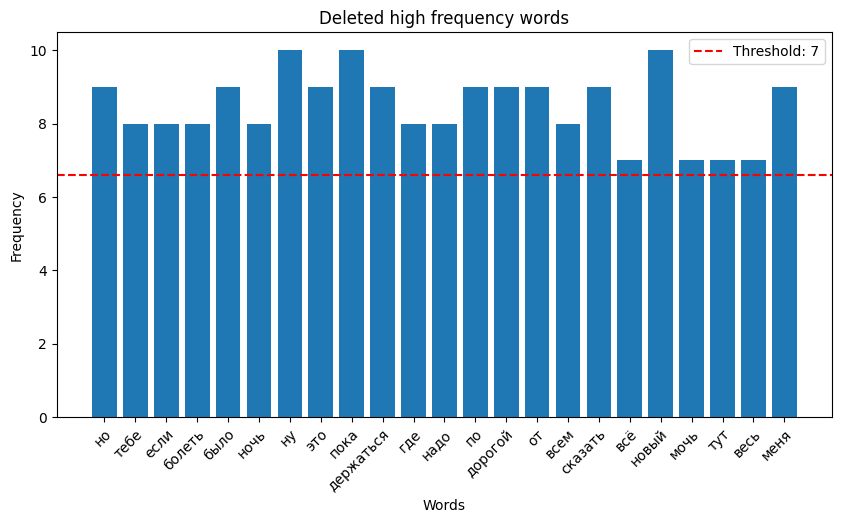

In [17]:

def visualize_word_frequencies(high_freq_words, threshold):
    # Create a single plot for the graph
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot word frequencies in the high_freq_words (words deleted)
    ax1.bar(high_freq_words.keys(), high_freq_words.values())
    ax1.set_title('Deleted high frequency words')
    ax1.set_xlabel('Words')
    ax1.set_ylabel('Frequency')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    # threshold with round intenger
    ax1.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.0f}')
    ax1.legend()

    # save plot to file
    # plt.savefig('words_deleted.png', bbox_inches='tight')
    plt.show()


_, high_freq_words, threshold = normalize_words_distibution(users_msgs_df['person_text'][0])
visualize_word_frequencies(high_freq_words, threshold)

In [21]:
users_msgs_df['text_length'] = users_msgs_df['person_text'].apply(lambda x: len(x))
# users_msgs_df.sample(n=5).head()
users_msgs_df['text_length'].describe()

count      30.000000
mean     2245.766667
std      2046.077942
min       787.000000
25%       907.000000
50%      1754.500000
75%      2490.000000
max      8811.000000
Name: text_length, dtype: float64

# Calculate letter frequency for each person

In [22]:
# Standard frequency of letters in Russian language
standart_rus_frequency = {'а': 8.01, 'б': 1.59, 'в': 4.54, 'г': 1.7, 'д': 2.98, 'е': 8.45, 'ё': 0.04, 'ж': 0.94, 'з': 1.65, 'и': 7.35, 'й': 1.21, 'к': 3.49, 'л': 4.4, 'м': 3.21, 'н': 6.7, 'о': 10.97, 'п': 2.81, 'р': 4.73, 'с': 5.47, 'т': 6.26, 'у': 2.62, 'ф': 0.26, 'х': 0.97, 'ц': 0.48, 'ч': 1.44, 'ш': 0.73, 'щ': 0.36, 'ъ': 0.04, 'ы': 1.9, 'ь': 1.74, 'э': 0.32, 'ю': 0.64, 'я': 2.01}

def calculate_letter_frequency(text: str, letter_set: Optional[Set[str]] = None) -> Dict[str, float]:
    calc_freq = {letter: text.count(letter) for letter in letter_set}
    total_count = sum(calc_freq.values())
    return {key: round((value / total_count)*100, 2) for key, value in calc_freq.items()}

# calculate letter frequency
users_msgs_df['letter_frequency'] = users_msgs_df['person_text'].apply(lambda x: calculate_letter_frequency(x, standart_rus_frequency))
users_msgs_df['person_text'] = users_msgs_df['person_text'].apply(lambda x: clean_text(x))
users_msgs_df.sample(n=5).head()


,person_id,person_text,text_length,letter_frequency
28,28,добрый вечер работаю программистом свободное в...,787,"{'а': 8.93, 'б': 2.38, 'в': 3.27, 'г': 2.38, '..."
21,21,привет устала сегодня очень много дел по дому ...,922,"{'а': 9.04, 'б': 1.81, 'в': 4.13, 'г': 0.65, '..."
1,1,максим тебе сколько лет делать москве меня хоб...,4261,"{'а': 8.32, 'б': 2.07, 'в': 3.6, 'г': 1.55, 'д..."
6,6,анна замужем заниматься маша поэтому мечтаю съ...,6122,"{'а': 8.76, 'б': 2.17, 'в': 3.91, 'г': 1.36, '..."
25,25,привет занимаешься талант в универе на инженер...,901,"{'а': 7.79, 'б': 2.21, 'в': 4.16, 'г': 1.04, '..."


# Calculate the mean and standard deviation frequency of letters in control group

In [24]:
df_expanded = pd.concat([users_msgs_df['person_id'], users_msgs_df['letter_frequency'].apply(pd.Series)], axis=1)

df_control_group = df_expanded.iloc[1:30]

df_compare_frequency_person_0 = pd.DataFrame(list(users_msgs_df['letter_frequency'][0].items()), columns=['Letter', 'Frequency']).set_index('Letter')

df_compare_frequency_person_0['Mean_control_group'] = df_control_group.drop(columns=['person_id']).mean()
df_compare_frequency_person_0['STD_control_group'] = df_control_group.drop(columns=['person_id']).std()
df_compare_frequency_person_0.sample(n=5).head()

,Frequency,Mean_control_group,STD_control_group
Letter,,,
р,4.96,4.508276,0.775523
щ,0.25,0.318966,0.182353
ы,1.34,1.606552,0.452085
ц,0.20,0.290690,0.189961
ь,2.11,2.690000,0.523314


# Calculate the Z-score for each letter and check anomaly.

In [25]:
df_compare_frequency_person_0['ZScore'] = (df_compare_frequency_person_0['Frequency'] - df_compare_frequency_person_0['Mean_control_group']) / df_compare_frequency_person_0['STD_control_group']

threshold = 2

df_compare_frequency_person_0['Anomaly'] = (df_compare_frequency_person_0['ZScore'].abs() > threshold)
df_compare_frequency_person_0.sample(n=5).head()

,Frequency,Mean_control_group,STD_control_group,ZScore,Anomaly
Letter,,,,,
и,5.80,5.716207,0.887917,0.094370,False
ю,0.76,1.136897,0.372953,-1.010575,False
ъ,0.04,0.020690,0.043089,0.448152,False
а,7.91,8.321724,0.858662,-0.479495,False
г,1.62,1.518966,0.410943,0.245860,False


# 6. Calculate between letters pronunciation and anomaly frequency between person_#0 and control group

In [26]:
tested_letter_pronunciation = {'а': 1, 'б': 1, 'в': 1, 'г': 1, 'д': 1, 'е': 1, 'ё': 1, 'ж': 0.5, 'з': 1, 'и': 1, 'й': 1, 'к': 1, 'л': 0.5, 'м': 1, 'н': 1, 'о': 1, 'п': 1, 'р': 0, 'с': 1, 'т': 1, 'у': 1, 'ф': 1, 'х': 1, 'ц': 1, 'ч': 0, 'ш': 0.5, 'щ': 0.5, 'ъ': 1, 'ы': 1, 'ь': 1, 'э': 1, 'ю': 1, 'я': 1}

df_compare_frequency_person_0['tested_letter_pronunciation'] = tested_letter_pronunciation.values()
corel_of_anomal_and_pronunciation = df_compare_frequency_person_0['Anomaly'].corr(df_compare_frequency_person_0['tested_letter_pronunciation'])
print(f'Correlation between animal frequency and problem letter production: {corel_of_anomal_and_pronunciation:.2f} (out of -1 to 1 possible)')

Correlation between animal frequency and problem letter production: -0.24 (out of -1 to 1 possible)


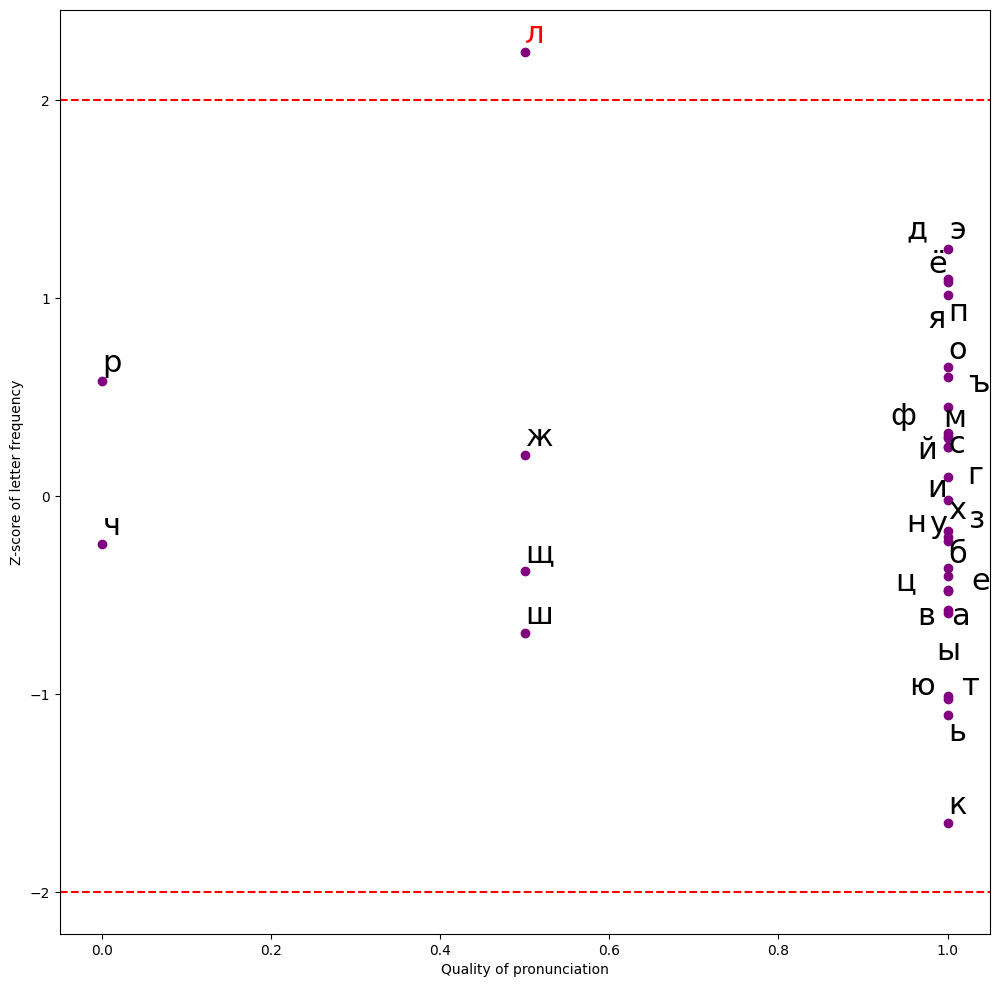

In [27]:
def plot_corel_of_anomal_and_pronunciation(df, threshold, corel_of_anomal_and_pronunciation):
    # Create figure and plot space
    fig, ax = plt.subplots(figsize=(12, 12))
    # make text labels bigger
    plt.rcParams.update({'font.size': 22})

    # Add x-axis and y-axis
    ax.scatter(df['tested_letter_pronunciation'], df['ZScore'], color='purple')

    # Set title and labels for axes and make them bigger
    plt.rcParams.update({'font.size': 22})
    ax.set(xlabel="Quality of pronunciation",
           ylabel="Z-score of letter frequency")

    # Add threshold lines
    ax.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.0f}')
    ax.axhline(y=-threshold, color='r', linestyle='--')

    # Adjust the text labels to minimize overlaps
    texts = []
    for i, letter in enumerate(df.index):
        z_score = df['ZScore'][i]
        text_color = 'red' if z_score < -threshold or z_score > threshold else 'black'
        texts.append(ax.text(df['tested_letter_pronunciation'][i], z_score, letter, ha='center', va='center', color=text_color))

    adjust_text(texts)
    plt.show()

plot_corel_of_anomal_and_pronunciation(df_compare_frequency_person_0, threshold, corel_of_anomal_and_pronunciation)


# Calculate the average word length for each person.

In [63]:
def average_word_length(text):
    valid_words = [word for word in text.split()]

    total_length = sum(len(word) for word in valid_words)
    average_length = total_length / len(valid_words)

    return average_length

df_words_msgs_length = pd.DataFrame({'person_id': users_msgs_df['person_id'], 'average_word_length': users_msgs_df['person_text'].apply(average_word_length)})
df_words_msgs_length['average_word_length'].describe()

count    30.000000
mean      5.153966
std       0.281491
min       4.433702
25%       5.056438
50%       5.124116
75%       5.309794
max       5.709924
Name: average_word_length, dtype: float64

# Calculate the Z-score.

In [64]:
df_filtered_average_word_length = df_words_msgs_length.iloc[1:30]
df_control_group_mean = df_filtered_average_word_length['average_word_length'].mean()
df_control_group_std = df_filtered_average_word_length['average_word_length'].std()

z_score_for_tested_average_word_length = (df_words_msgs_length['average_word_length'][0] - df_control_group_mean) / df_control_group_std

# Compare word length for person_#0 and control group.

In [32]:
if abs(z_score_for_tested_average_word_length) > 2:
    print(f'Anomaly detected, absolute value of the z-score = {z_score_for_tested_average_word_length:.2f} is over two standard deviations away from the mean.')
else:
    print(f'Anomaly not detected, absolute value of the z-score = {z_score_for_tested_average_word_length:.2f} is not over two standard deviations away from the mean.')


Anomaly not detected, absolute value of the z-score = 1.78 is not over two standard deviations away from the mean.


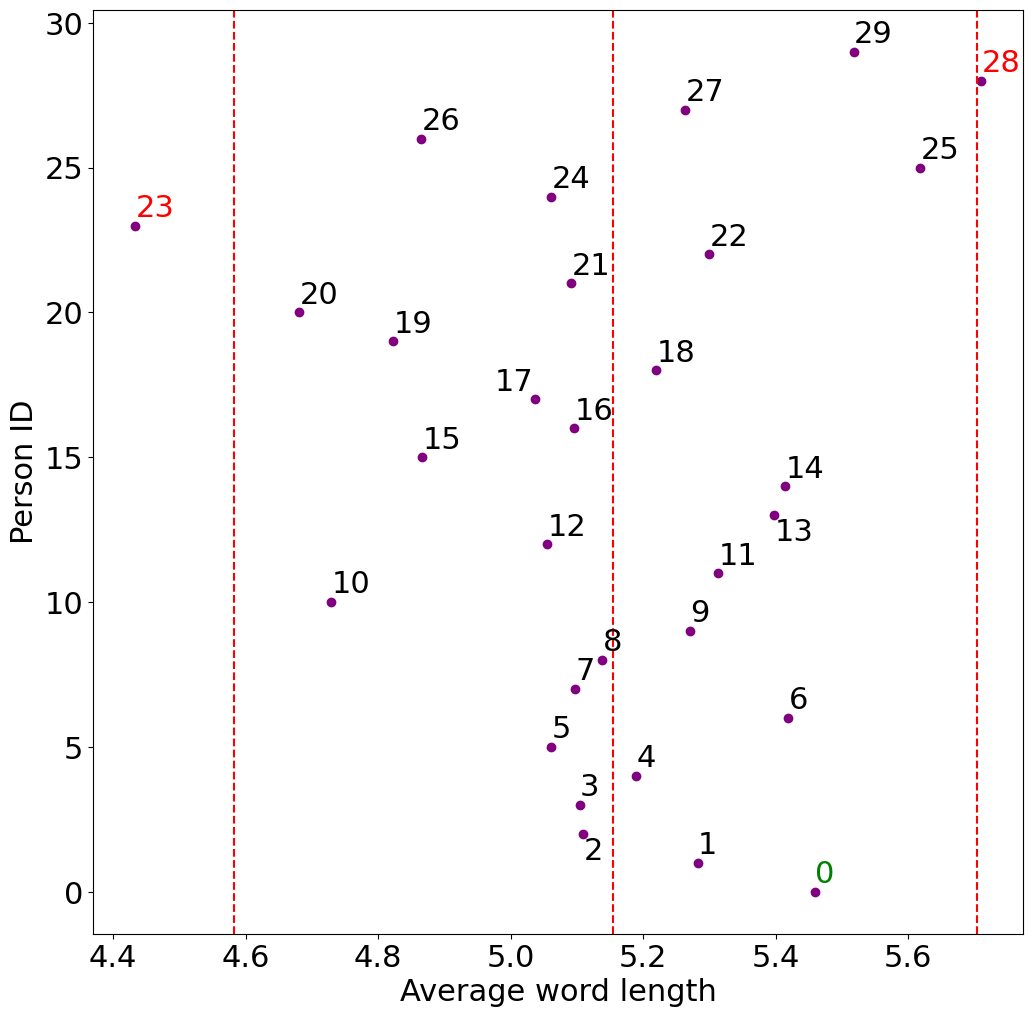

In [66]:
def plot_z_score_and_average_word_length(df, upper_threshold, lower_threshold):
    # Create figure and plot space
    fig, ax = plt.subplots(figsize=(12, 12))
    # make text labels bigger
    plt.rcParams.update({'font.size': 22})

    # Add x-axis and y-axis
    ax.scatter(df['average_word_length'], df['person_id'], color='purple')

    # Set title and labels for axes and make them bigger
    plt.rcParams.update({'font.size': 22})
    ax.set(xlabel="Average word length",
           ylabel="Person ID")

    # Add threshold lines
    ax.axvline(x=df['average_word_length'].mean(), color='r', linestyle='--', label=f'Mean: {df["average_word_length"].mean():.2f}')
    ax.axvline(x=upper_threshold, color='r', linestyle='--', label=f'STD: {df["average_word_length"].std():.2f}')
    ax.axvline(x=lower_threshold, color='r', linestyle='--')

    # Adjust the text labels to minimize overlaps
    texts = []
    for i, person_id in enumerate(df['person_id']):
        average_word_length = df['average_word_length'][i]
        if person_id == 0:
            text_color = 'green'
        else:
            text_color = 'red' if average_word_length < lower_threshold or average_word_length > upper_threshold else 'black'
        texts.append(ax.text(average_word_length, person_id, person_id, ha='center', va='center', color=text_color))

    adjust_text(texts)
    plt.show()

upper_threshold = df_control_group_mean + df_control_group_std * 2
lower_threshold = df_control_group_mean - df_control_group_std * 2

plot_z_score_and_average_word_length(df_words_msgs_length, upper_threshold, lower_threshold)

In [67]:
df_words_msgs_length['average_word_length'][0]

5.459037711313394